In [1]:
# %matplotlib notebook
import numpy as np
from matplotlib import image, pyplot as plt
import json
from celluloid import Camera

_ZI = np.complex(0, 1)

# Waves on an infinite string
We have to satisfy
\begin{align}
m_0 u_{tt} - \kappa_0 u_{xx} = 0\quad\textrm{for $x<0$},\\
m_1 u_{tt} - \kappa_1 u_{xx} = 0\quad\textrm{for $x>0$},\\
\kappa_0u_x(0^-) = \kappa_1u_x(0^+),\\
u(0^-) = u(0^+),\\
\end{align}
The governing equations are the wave equations
\begin{align}
&u_{tt} - c_i^2 u_{xx} = 0,\\
&c_i^2=\frac{\kappa_i}{m_i}.
\end{align}

## Time-harmonic solution
If $u(x,t) = \textrm{Re}\big[U(x)\textrm{e}^{-\textrm{i}\omega t}\big]$,
\begin{align}
&U_{xx} + k_i^2 U = 0,\\
&k_i^2=\frac{\omega^2}{c_i^2}=\frac{m_i\omega^2}{\kappa_i}.
\end{align}
The general solution is
\begin{align}
&U(x) = 
\begin{cases}
i^+\textrm{e}^{\textrm{i}k_0x} + s^+\textrm{e}^{-\textrm{i}k_0x} \quad\textrm{for $x<0$},\\
s^-\textrm{e}^{\textrm{i}k_1x} + i^-\textrm{e}^{-\textrm{i}k_1x} \quad\textrm{for $x>0$},
\end{cases}
\end{align}
with $i^\pm$ being (known) incident wave amplitudes and $s^\pm$ being (unknown) scattered wave amplitudes.
The boundary conditions imply that
\begin{align}
&i^+ + s^+ = i^- + s^-,\\
&\textrm{i}k_0(i^+ - s^+) = -\textrm{i}k_1(i^- - s^-),
\end{align}
so
\begin{align}
&\begin{pmatrix}
s^+ \\ s^-
\end{pmatrix} = 
\frac{1}{k_0+k_1}
\begin{pmatrix}
k_0 - k_1 & 2k_1 \\
2k_0 & k_1 - k_0
\end{pmatrix}
\begin{pmatrix}
i^+ \\ i^-
\end{pmatrix}
 = \begin{pmatrix}
R^+ & T^- \\
T^+ & R^-
\end{pmatrix}
\begin{pmatrix}
i^+ \\ i^-
\end{pmatrix}.
\end{align}
Note that the scattering is independent of wave period since $\omega$ factors in $k_0$ and $k_1$ cancel out.

## Energy conservation
\begin{align}
0&=\int_{-\infty}^\infty\big(
(U_{xx}+k_i^2U)U^*
-
(U^{*}_{xx}+k_i^2U^*)U
\big)\textrm{d}x\\
&=\big[U_xU^* - UU_x^*\big]^{\infty}_{-\infty}\\
&=2\textrm{i}k_1\big(|s^-|^2-|i^-|^2\big)
- 2\textrm{i}k_0\big(|i^+|^2-|s^+|^2\big)
\end{align}
Let $\alpha = {k_1}/{k_0}$. Then if $i^+=1$ and $i^-=0$, $|R^+|^2 + \alpha |T^+|^2 = 1$. Similarly, $|R^-|^2 + \alpha^{-1} |T^-|^2 = 1$.

## Properties of a segment of string

In [2]:
class ElasticString:

    def __init__(self, m=1, kappa=4, period=3, xlim = None):
        """
        Class to manage string properties
        
        Parameters:
        -----------
        m : float
            mass per unit length (kg/m)
        kappa : float
            string stiffness (Pa/m)
        period : float
            wave period (s)
        xlim : array-like
            (x0, x1), where x0 is the LHS limit and x1 si the RHS limit
            default is (-numpy.Inf, numpy.Inf)
        """
        self.m = m
        self.kappa = kappa
        self.period = period
        self.infinite = False
        self.semi_infinite = False
        if xlim is None or tuple(xlim) == (-np.Inf, np.Inf):
            self.infinite = True
            self.xlim = np.array([-np.Inf, np.Inf])
        else:
            self.xlim = np.array(xlim)
            self.semi_infinite = not np.all(np.isfinite(xlim))
        assert(self.xlim[0] < self.xlim[1])
        assert(len(self.xlim) == 2)


    @property
    def params(self):
        return dict(
            m=self.m,
            kappa=self.kappa,
            period=self.period,
        )


    @property
    def c(self):
        """
        Returns:
        --------
        c : float
            wave speed (m/s)
        """
        return np.sqrt(self.kappa/self.m)
    
    
    @property
    def omega(self):
        """
        Returns:
        --------
        omega : float
            radial wave frequency (1/s)
            = 2\pi/period
        """
        return 2*np.pi/self.period # 1/s


    @property
    def k(self):
        """
        Returns:
        --------
        k : numpy.array(float)
            wave frequency (1/m)
            = 2\pi/wavelength
        """
        return np.array([self.omega/self.c])

    
    @property
    def num_modes(self):
        """
        Returns:
        --------
        num_modes : int
            number of wave modes
        """
        return len(self.k)
    
    
    def is_in_domain(self, x):
        """
        Parameters:
        -----------
        x : numpy.array(float)
        
        Returns:
        --------
        in_dom : numpy.array(bool)
            bool same size as x marking which members are in the domain
        """
        x0, x1 = self.xlim
        return (x>=x0) * (x<=x1)

    
    def get_displacement(self, x, a0, a1):
        """
        Calculate a displacement profile

        Parameters:
        -----------
        x : numpy.array(float)
            positions to evaluate the displacement
        a0 : numpy.array(float)
            wave amplitudes for waves travelling from left to right
        a1 : numpy.array(float)
            wave amplitudes for waves travelling from right to left

        Returns:
        --------
        u : numpy.array(float)
            complex displacement U evaluated at x
        """
        u = np.full_like(x, np.nan, dtype=np.complex)
        b = self.is_in_domain(x)
        xb = x[b]
        x0, x1 = self.xlim
        if self.infinite:
            x0 = x1 = 0
        elif self.semi_infinite:
            x0 = x1 = self.xlim[np.isfinite(self.xlim)]
        u[b] = np.exp(_ZI*np.outer(xb - x0, self.k)).dot(a0)  # (nx,nk) x (nk,1) = (nx,1)
        u[b] += np.exp(_ZI*np.outer(x1 - xb, self.k)).dot(a1) # (nx,nk) x (nk,1) = (nx,1)
        return u


    def get_reversed(self):
        return ElasticString(**self.params, xlim=-self.xlim[::-1])

## Scattering by a change in string properties

In [3]:
class Scatterer:
    
    def __init__(self, media):
        """
        Base scatterer class.
        Default calculates the scattering by a change in elastic string properties
        
        Parameters:
        -----------
        media : ElasticString or subclass
            object containing properties of the string segment to the left of the boundary
        position : float
            x value where the boundary occurs
        """
        self.media = media
        assert(len(media)>1)
        om = [med.omega for med in self.media]
        assert(len(set(om)) == 1)

        
    @property
    def params(self):
        return dict(media)
    

    @property
    def period(self):
        """
        Returns:
        --------
        period : float
            wave period (s)
        """
        return self.media[0].period
    

    @property
    def omega(self):
        """
        Returns:
        --------
        omega : float
            radial wave frequency (1/s)
            = 2\pi/period
        """
        return self.media[0].omega


    @property
    def intrinsic_admittance(self):
        """
        Returns:
        --------
        intrinsic_admittance : float
            coefficient \alpha in the conservation of energy equation
        """
        return self.media[-1].k[0]/self.media[0].k[0]


    @property
    def xlim(self):
        """
        Returns:
        --------
        xlim : tuple
            left and right hand limits of scatterer
            (both are self.position for a sharp change in properties)
        """
        return self.media[0].xlim[1], self.media[-1].xlim[0]


    def solve(self):
        """
        Solve the boundary conditions to set the scattering matrices
        
        Sets:
        -----
        Rp_ : numpy.ndarray(float)
            R^+ matrix (reflection of waves to right)
        Rm_ : numpy.ndarray(float)
            R^- matrix (reflection of waves to left)
        Tp_ : numpy.ndarray(float)
            T^+ matrix (transmission of waves to right)
        Tm_ : numpy.ndarray(float)
            T^- matrix (transmission of waves to left)
        """
        k0 = self.media[0].k[0]
        k1 = self.media[1].k[0]
        fac = 1/(k0 + k1)
        self.Rp = fac*np.array([[k0-k1]])
        self.Tm = fac*np.array([[2*k1]])
        self.Tp = fac*np.array([[2*k0]])
        self.Rm = fac*np.array([[k1-k0]])


    def get_solution_params(self, index, ip, im):
        """
        Get amplitudes of scattered waves

        Parameters:
        -----------
        ip : numpy.array(float)
            wave amplitudes of incident waves to right
        im : numpy.array(float)
            wave amplitudes of incident waves to left

        Returns:
        --------
        sp : numpy.array(float)
            wave amplitudes for waves scattered to left
        sm : numpy.array(float)
            wave amplitudes for waves scattered to right
        """
        if index == 0:
            sp = self.Rp.dot(ip) + self.Tm.dot(im)
            return dict(a0=ip, a1=sp.flatten()) # x<0
        sm = self.Tp.dot(ip) + self.Rm.dot(im)
        return dict(a0=sm.flatten(), a1=im) # x>0

        
    def get_reversed(self):
        media = []
        for med in self.media[::-1]:
            media += [med.get_reversed()]
        return Scatterer(media)


    def test_energy(self):
        """
        Test energy is conserved
        """
        alp = self.intrinsic_admittance
        e = np.abs(self.Rp[0,0])**2 + alp*np.abs(self.Tp[0,0])**2
        assert(np.abs(e-1) < 1e-8)
        e = np.abs(self.Rm[0,0])**2 + np.abs(self.Tm[0,0])**2/alp
        assert(np.abs(e-1) < 1e-8)
        print('Energy is OK')    


    def test_boundary_conditions(self, inc_amps=None):
        """
        Test boundary conditions are satisfied
        """
        if inc_amps is None:
             inc_amps = np.array([1]), np.array([0.5])
        ip, im = inc_amps
        sp = self.get_solution_params(0, ip, im)['a1']
        sm = self.get_solution_params(-1, ip, im)['a0']
        u_m = ip.sum() + sp.sum() #U(0^+)
        u_p = im.sum() + sm.sum() #U(0^-)
        ux_m = _ZI*self.media[0].k.dot(ip - sp)
        ux_p = _ZI*self.media[-1].k.dot(sm - im)
        print(f"u(0) = {u_m} = {u_p}")
        print(f"u_x(0) = {ux_m} = {ux_p}")
        assert(np.abs(u_m - u_p) < 1e-8)
        assert(np.abs(ux_m - ux_p) < 1e-8)
        print("Boundary conditions are OK")
        


    def test_swap(self):
        """
        Test we get the expected results if the left-hand and right-hand string properties are swapped
        """
        swap = self.get_reversed()
        swap.solve()
        assert(np.allclose(self.Rp, swap.Rm))
        assert(np.allclose(self.Tp, swap.Tm))
        assert(np.allclose(self.Rm, swap.Rp))
        assert(np.allclose(self.Tm, swap.Tp))
        print('Swap is OK')


    def get_displacement(self, x, inc_amps=None):
        """
        Get displacement profile outside the scatterer

        Parameters:
        -----------
        x : numpy.array(float)
            positions to evaluate the displacement
        inc_amps : list or tuple
            (ip,im) with
                ip : numpy.array(float)
                    wave amplitudes of incident waves to right
                im : numpy.array(float)
                    wave amplitudes of incident waves to left

        Returns:
        --------
        u : numpy.array(float)
            complex displacement U evaluated at x
        label : numpy.array(int)
            label of which media each point of x is in
        """
        if inc_amps is None:
            inc_amps = (np.array([1]), np.array([0]))
        ip, im = inc_amps
        u = np.zeros_like(x, dtype=np.complex)
        x0, x1 = self.xlim
        lbl = np.zeros_like(x, dtype=int)
        for i, med in enumerate(self.media):
            b = med.is_in_domain(x)
            lbl[b] = i
            if not np.any(b):
                continue
            kw = self.get_solution_params(i, ip, im)
            u[b] = med.get_displacement(x[b], **kw)
        return u, lbl
       

    @property
    def default_plot_range(self):
        fac = 2.5
        lam = 2*np.pi/np.max([np.max(self.media[i].k.real) for i in [0,-1]])
        if self.media[0].infinite:
            return - fac*lam, fac*lam, lam
        xlim = self.media[0].xlim
        x0 = xlim[0]
        if self.media[0].semi_infinite:
            x0 = xlim[1] - fac*lam
        xlim = self.media[-1].xlim
        x1 = xlim[1]
        if self.media[-1].semi_infinite:
            x1 = xlim[0] + fac*lam
        return x0, x1, lam


    def plot_displacement(self, ax=None, t=0, x=None, inc_amps=None, no_title=False, **kwargs):
        """
        Plot displacement profile

        Parameters:
        -----------
        t : float
            time (s)
        x : numpy.array(float)
            positions (m) to evaluate the displacement
        inc_amps : list or tuple
            (ip,im) with
                ip : numpy.array(float)
                    wave amplitudes of incident waves to right
                im : numpy.array(float)
                    wave amplitudes of incident waves to left
        kwargs for matplotlib.pyplot.plot

        Returns:
        --------
        ax : matplotlib.axes._subplots.AxesSubplot
            plot axis
        """
        if x is None:
            # get the smallest wavelength
            x0, x1, lam = self.default_plot_range
            x = np.linspace(x0, x1, 100*int((x1-x0)/lam))
            
        # calc displacement
        u, lbl = self.get_displacement(
            x, inc_amps=inc_amps)
        u *= np.exp(-_ZI*self.omega*t)
        umax = 1.1*np.abs(u).max()
        # plot different media separately to give each a different colour
        if ax is None:
            fig = plt.figure(figsize=(14,7))
            ax = fig.add_subplot(111)
        for i in range(len(self.media)):
            b = (lbl == i)
            ax.plot(x[b], u[b].real, **kwargs)
        
        # decorate
        if not no_title:
            ax.set_title(f"u at t={t}s")
        ax.set_xlabel("x, m")
        ax.set_ylabel("u, m")
        ax.set_xlim([x.min(), x.max()])
        ax.set_ylim([-umax, umax])
        return ax
    

    def animate_displacement(self, figname='animation.gif', **kwargs):
        """
        make an animation of the displacement (saved to file)
        
        Parameters:
        -----------
        figname : str
        kwargs for StringBoundary.plot_displacement
        """
        tvec = np.linspace(0, self.period, 24)
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111)
        cam = Camera(fig)
        for t in tvec[:-1]:
            ax = self.plot_displacement(t=t, ax=ax, no_title=True, **kwargs)
            plt.pause(.1)
            cam.snap()
        anim = cam.animate()
        print(f'Saving {figname}')
        plt.close()
        anim.save(figname, fps=12)

## Example calculation
### Set string props to left and right of boundary

In [4]:
period = 4
lhs = ElasticString(m=2, period=period, xlim=[-np.Inf, 0])
rhs = ElasticString(kappa = 13, period=period, xlim=[0, np.Inf])

### Solve scattering  problem

In [5]:
bdy = Scatterer([lhs, rhs])
bdy.solve()

### Run tests

In [6]:
bdy.test_boundary_conditions()
bdy.test_swap()
bdy.test_energy()

u(0) = 1.7182709533097467 = 1.7182709533097467
u_x(0) = 0.31292229368093694j = 0.3129222936809368j
Boundary conditions are OK
Swap is OK
Energy is OK


### Plot the displacement at a given time

<AxesSubplot:title={'center':'u at t=0.0s'}, xlabel='x, m', ylabel='u, m'>

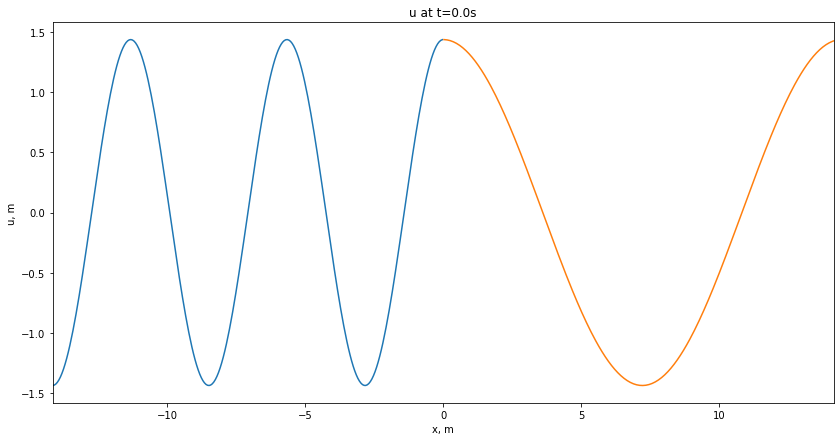

In [7]:
bdy.plot_displacement(t=0.)

### Animate displacement

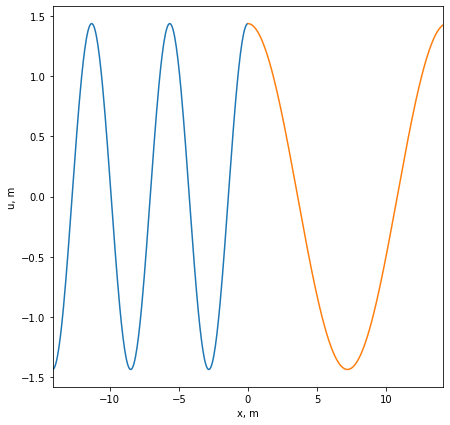

MovieWriter ffmpeg unavailable; using Pillow instead.


Saving animation.gif


In [8]:
out = 'animation.gif'
bdy.animate_displacement(out)

### Display animation of displacement
![SegmentLocal](animation.gif "segment")

## Scattering by two boundaries in series
\begin{align}
&\textbf{s}^+ = \textbf{R}_0^+\textbf{i}^+
+ \textbf{T}_0^-\textbf{D}\textbf{b}_{0}\\
&\textbf{a} = \textbf{T}_0^+\textbf{i}^+
+ \textbf{R}_0^-\textbf{D}\textbf{b}\\
&\textbf{b} = \textbf{T}_{1}^-\textbf{i}^-
+ \textbf{R}_{1}^+\textbf{D}\textbf{a}\\
&\textbf{s}^- = \textbf{R}_{1}^-\textbf{i}^-
+ \textbf{T}_{1}^+\textbf{D}\textbf{a}
\end{align}
Combining these gives
\begin{align}
&
\begin{pmatrix}
\textbf{a} \\ \textbf{b}
\end{pmatrix}
=
\begin{pmatrix}
\textbf{T}_0^+ & \textbf{0} \\ \textbf{0} & \textbf{T}_1^-
\end{pmatrix}
\begin{pmatrix}
\textbf{i}^+ \\ \textbf{i}^-
\end{pmatrix}
+
\begin{pmatrix}
\textbf{0} & \textbf{R}_0^-\textbf{D} \\ \textbf{T}_{1}^+\textbf{D} & \textbf{0}
\end{pmatrix}
\begin{pmatrix}
\textbf{a} \\ \textbf{b}
\end{pmatrix}.
\end{align}

## Multiple scattering
\begin{align}
&\textbf{s}^+ = \textbf{R}_0^+\textbf{i}^+
+ \textbf{T}_0^-\textbf{D}_{0}\textbf{b}_{0}\\
&\textbf{a}_0 = \textbf{T}_0^+\textbf{i}^+
+ \textbf{R}_0^-\textbf{D}_{0}\textbf{b}_{0}\\
&\textbf{a}_n = \textbf{T}_n^+\textbf{D}_{n-1}\textbf{a}_{n-1}
+ \textbf{R}_n^-\textbf{D}_{n}\textbf{b}_{n}\\
&\textbf{b}_n = \textbf{T}_{n+1}^-\textbf{D}_{n+1}\textbf{b}_{n+1}
+ \textbf{R}_{n+1}^+\textbf{D}_{n}\textbf{a}_{n}\\
&\textbf{b}_{N-1} = \textbf{T}_{N}^-\textbf{i}^-
+ \textbf{R}_{N}^+\textbf{D}_{N-1}\textbf{a}_{N-1}\\
&\textbf{s}^- = \textbf{R}_{N}^-\textbf{i}^-
+ \textbf{T}_{N}^+\textbf{D}_{N-1}\textbf{a}_{N-1}
\end{align}
Combining these gives
\begin{align}
&
\begin{pmatrix}
\textbf{a} \\ \textbf{b}
\end{pmatrix}
=
\begin{pmatrix}
\textbf{B}^+ & \textbf{0} \\ \textbf{0} & \textbf{B}^-
\end{pmatrix}
\begin{pmatrix}
\textbf{i}^+ \\ \textbf{i}^-
\end{pmatrix}
+
\begin{pmatrix}
\textbf{A}_{00} & \textbf{A}_{11} \\ \textbf{A}_{10} & \textbf{A}_{11}
\end{pmatrix}
\begin{pmatrix}
\textbf{a} \\ \textbf{b}
\end{pmatrix},
\end{align}
where
\begin{align}
&\textbf{B}^+ = \begin{pmatrix}
\textbf{T}_0^+\\ \textbf{0} \\ \cdots \\  \textbf{0}
\end{pmatrix},
\quad
\textbf{B}^- = \begin{pmatrix}
\textbf{0} \\ \cdots \\  \textbf{0} \\ \textbf{T}_N^-
\end{pmatrix},
\\
&\textbf{A}_{00} = \begin{pmatrix}
\textbf{0}                     & \textbf{0} & \textbf{0} & \cdots & \textbf{0} \\
\textbf{T}_1^+\textbf{D}_0     & \textbf{0} & \textbf{0} & \cdots & \textbf{0} \\
\textbf{0} & \textbf{T}_2^+\textbf{D}_1     & \textbf{0} & \cdots & \textbf{0} \\
\cdots & \cdots & \cdots & \cdots & \cdots \\
\textbf{0} & \cdots & \textbf{0}     & \textbf{T}_{N-1}^+\textbf{D}_{N-2} & \textbf{0} \\
\end{pmatrix},
\quad
\textbf{A}_{01} = \begin{pmatrix}
\textbf{R}_0^-\textbf{D}_0     & \textbf{0} & \textbf{0} & \cdots & \textbf{0} \\
\textbf{0} & \textbf{R}_1^-\textbf{D}_1     & \textbf{0} & \cdots & \textbf{0} \\
\cdots & \cdots & \cdots & \cdots & \cdots \\
\textbf{0} & \cdots & \textbf{0}     & \textbf{R}_{N-2}^-\textbf{D}_{N-2} & \textbf{0} \\
\textbf{0} & \textbf{0} & \cdots & \textbf{0} & \textbf{R}_{N-1}^-\textbf{D}_{N-1}
\end{pmatrix},\\
&\textbf{A}_{01} = \begin{pmatrix}
\textbf{R}_1^+\textbf{D}_0     & \textbf{0} & \textbf{0} & \cdots & \textbf{0} \\
\textbf{0} & \textbf{R}_2^+\textbf{D}_1     & \textbf{0} & \cdots & \textbf{0} \\
\cdots & \cdots & \cdots & \cdots & \cdots \\
\textbf{0} & \cdots & \textbf{0}     & \textbf{R}_{N-1}^+\textbf{D}_{N-2} & \textbf{0} \\
\textbf{0} & \textbf{0} & \cdots & \textbf{0} & \textbf{R}_{N}^+\textbf{D}_{N-1}
\end{pmatrix},
\quad
\textbf{A}_{11} = \begin{pmatrix}
\textbf{0} & \textbf{T}_1^-\textbf{D}_1     & \textbf{0} & \cdots & \textbf{0} \\
\textbf{0} & \textbf{0} & \textbf{T}_2^-\textbf{D}_2 & \cdots & \textbf{0} \\
\cdots & \cdots & \cdots & \cdots & \cdots \\
\textbf{0} & \textbf{0}  &  \textbf{0}  & \cdots  & \textbf{T}_{N-1}^-\textbf{D}_{N-1} \\
\textbf{0} & \textbf{0} & \textbf{0} & \cdots & \textbf{0}
\end{pmatrix}.
\end{align}